O notebook apresenta uma descrição dos experimentos realizados para treinar um modelo de aprendizado de máquina com o objetivo de classificar imagens do conjunto de dados Snapshot Serengeti. Esse conjunto consiste em uma grande coleção de imagens de animais selvagens capturadas no Parque Nacional Serengeti, localizado na Tanzânia, e está disponível através do link https://lila.science/datasets/snapshot-serengeti.

Para o treinamento, foram utilizadas imagens das primeiras e décimas temporadas, sendo realizada uma segmentação dos dados para obter as classes mais frequentes, ou seja, aquelas com número de imagens superior a 300. Essa segmentação resultou em 15 classes principais para o treinamento.

Inicialmente, utilizou-se uma rede neural convolucional Resnet-18 pré-treinada, que obteve um desempenho considerável, atingindo cerca de 85% de precisão após diversos treinamentos. Posteriormente, foram realizados outros treinamentos utilizando-se uma rede neural convolucional mais simples, a AlexNet, porém os resultados obtidos foram inferiores, com uma precisão de cerca de 77%.

In [2]:
#Bibliotecas utilizadas
import os
import time
import torch
import torchvision
import torchvision.transforms as T
from skimage import io
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
from PIL import Image
from torch.nn.parallel import DataParallel

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [3]:
n = 0
train_l_sum = 0.0
train_acc_sum = 0.0
start = time.time()

#Hiperparâmetros para treinamento da Rede Neural 
args = {
    'batch_size': 256,
    'num_workers': 4,
    'num_epochs': 50,
    'learning_rate': 0.001
}


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
#Clase para utilização de um conjunto de dados personalizados
class AnimalImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations['image_path_rel'][index]
        image = io.imread(img_name)
        y_label = torch.tensor(self.annotations['label'][index])

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [5]:
#Paraleliza o treinamento em duas gpus
DataParallel.device_ids = [0,1]

model = DataParallel(torchvision.models.alexnet(pretrained=True))
model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


DataParallel(
  (module): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
   

### Modelo ###
A ResNet18 é uma rede neural convolucional pré-treinada com 18 camadas, amplamente utilizada em tarefas de classificação de imagens. Sua eficiência é comprovada por ser relativamente pequena em comparação com outras arquiteturas mais profundas, o que requer um desempenho computacional menor. A ResNet18 é pré-treinada em grandes conjuntos de dados, como o ImageNet, permitindo que ela aprenda recursos básicos de baixo nível.

In [6]:
# Model Resnet18 
model = torchvision.models.resnet18(pretrained=True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#Define e retorna o DataLoader
def load_data():
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size = args['batch_size'],
                              shuffle=True,
                              pin_memory = True,
                              num_workers=4)

    val_loader =  DataLoader(dataset=val_dataset,
                             batch_size = args['batch_size'],
                             shuffle=False,
                             pin_memory = True,
                             num_workers=4)

    return train_loader, val_loader


#Obtém a acurácia da rede em cima de um conjunto de dados
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n, l = torch.Tensor([0]), 0, 0
    net.eval()
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            # Apply the model
            y_hat = net(X)
            l += loss(y_hat, y).sum()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
    return acc_sum.item() / n, l.item() / len(data_iter)


#Treinamento e validação
def train_validate(model, train_iter, test_iter, optimizer, loss, num_epochs):
    print('training on', device)
    for epoch in range(num_epochs):
        model.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            optimizer.zero_grad()
            l = loss(y_pred, y).sum()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_pred.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, model, loss)
        #Update train/val loss and acc for the epoch
        train_losses.append(train_l_sum / len(train_iter))
        train_correct.append(train_acc_sum / n)
        test_losses.append(test_loss)
        test_correct.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, ''test acc %.3f, time %.1f min' % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, test_acc, (time.time() - start) / 60))



#Checa a acurácia e outras métricas(Precision, Recall, F1) no conjunto de testes
def check_accuracy_test_metrics(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            
        accuracy = float(num_correct) / float(num_samples) * 100
        f1 = f1_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        
        print(f'Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')
        
        cm = confusion_matrix(y_true, y_pred)
        classes = np.arange(23)
        fig, ax = plt.subplots(figsize=(15, 15))  # Set the figsize parameter to increase the size of the image
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               ylabel='True label',
               xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        
        return

## Primeiro Treinamento ##


In [13]:
args

{'batch_size': 256, 'num_workers': 4, 'num_epochs': 50, 'learning_rate': 0.001}

In [15]:
#Tamanho dos dados de treino, teste e validação
train.shape, test.shape, val.shape

NameError: name 'train' is not defined

### Data Augmentation ###
Para o treinamento, foi utilizada a técnica de Data Augmentation, que consiste em uma técnica de pré-processamento de dados usada para aumentar o tamanho do conjunto de dados, através da geração de novas amostras. Para gerar novas amostras, diversas transformações podem ser realizadas, como rotações, reflexões, escalas, translações, entre outras. Essa técnica permite aumentar a diversidade e a variação dos dados, o que resulta em um melho desempenho e generalização do modelo

In [10]:
transform = T.Compose([
    T.ToPILImage(),
    CropCenter(256),
    T.RandomGrayscale(0.5),
    T.RandomAutocontrast(0.5),
    T.RandomHorizontalFlip(0.5),
    T.Resize(224),
    T.ColorJitter(brightness=(0.5,1.5)),
    T.ToTensor()
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

NameError: name 'CropCenter' is not defined

In [ ]:
#Definição da função de perda e do otimizador

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = args['learning_rate'])

In [28]:
#Treinamento

train_iter, val_iter = load_data()

start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')

training on cuda:0
epoch 1, train loss 1.1810, train acc 0.697, test loss 0.8822, test acc 0.730, time 0.9 min
epoch 2, train loss 0.5407, train acc 0.833, test loss 0.9896, test acc 0.718, time 0.9 min
epoch 3, train loss 0.4244, train acc 0.868, test loss 0.6498, test acc 0.798, time 0.9 min
epoch 4, train loss 0.3292, train acc 0.895, test loss 1.6472, test acc 0.632, time 0.9 min
epoch 5, train loss 0.2756, train acc 0.911, test loss 0.7337, test acc 0.794, time 1.0 min
epoch 6, train loss 0.2405, train acc 0.922, test loss 0.8019, test acc 0.781, time 1.0 min
epoch 7, train loss 0.2102, train acc 0.933, test loss 0.7054, test acc 0.807, time 1.0 min
epoch 8, train loss 0.1744, train acc 0.941, test loss 0.7481, test acc 0.814, time 1.0 min
epoch 9, train loss 0.1565, train acc 0.950, test loss 0.7971, test acc 0.795, time 1.0 min
epoch 10, train loss 0.1383, train acc 0.956, test loss 0.7660, test acc 0.818, time 1.0 min
epoch 11, train loss 0.1085, train acc 0.967, test loss 0.95

Got 3651 / 4350 with accuracy 83.93 %


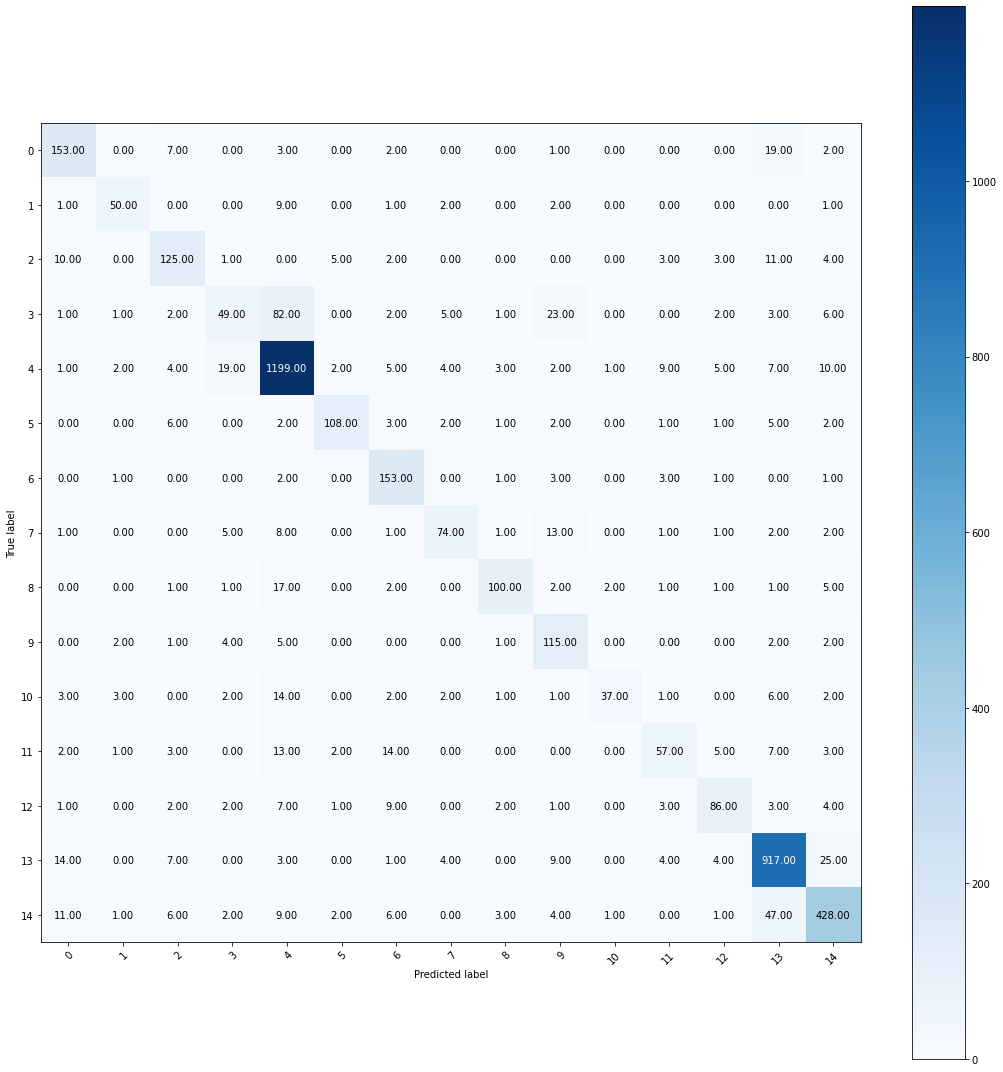

In [29]:
#Acurácia dos dados de teste e matrix de confusão

teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

#### Comportamento da Loss ao decorrer da época no Primeiro Treinamento ####

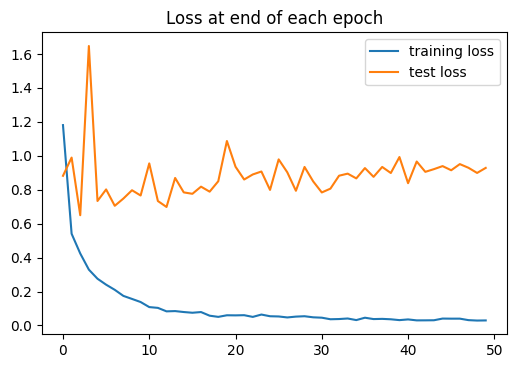

In [31]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Segundo Treinamento

In [35]:
#Aumentando o número de épocas
args['num_epochs'] = 100

In [41]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomGrayscale(0.5),
    T.RandomAutocontrast(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.Resize(224),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor()
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')


training on cuda:0
epoch 1, train loss 0.7685, train acc 0.781, test loss 0.7583, test acc 0.767, time 1.1 min
epoch 2, train loss 0.4624, train acc 0.857, test loss 0.6227, test acc 0.800, time 1.1 min
epoch 3, train loss 0.3649, train acc 0.882, test loss 0.5746, test acc 0.819, time 1.1 min
epoch 4, train loss 0.3281, train acc 0.892, test loss 0.5197, test acc 0.844, time 1.1 min
epoch 5, train loss 0.2833, train acc 0.907, test loss 0.5628, test acc 0.827, time 1.1 min
epoch 6, train loss 0.2574, train acc 0.915, test loss 0.5457, test acc 0.835, time 1.1 min
epoch 7, train loss 0.2467, train acc 0.918, test loss 0.5352, test acc 0.848, time 1.1 min
epoch 8, train loss 0.2160, train acc 0.926, test loss 0.5580, test acc 0.849, time 1.1 min
epoch 9, train loss 0.2023, train acc 0.930, test loss 0.8851, test acc 0.784, time 1.1 min
epoch 10, train loss 0.1839, train acc 0.938, test loss 0.5841, test acc 0.837, time 1.1 min
epoch 11, train loss 0.1880, train acc 0.934, test loss 0.59

epoch 97, train loss 0.0321, train acc 0.989, test loss 1.0248, test acc 0.822, time 1.0 min
epoch 98, train loss 0.0398, train acc 0.987, test loss 1.2465, test acc 0.794, time 1.0 min
epoch 99, train loss 0.0291, train acc 0.991, test loss 1.0023, test acc 0.823, time 1.1 min
epoch 100, train loss 0.0328, train acc 0.989, test loss 0.9848, test acc 0.827, time 1.1 min
Tempo de treinamento: 105.61 minutos


In [1]:
#Acurácia dos dados de teste e matrix de confusão
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

NameError: name 'AnimalImageDataset' is not defined

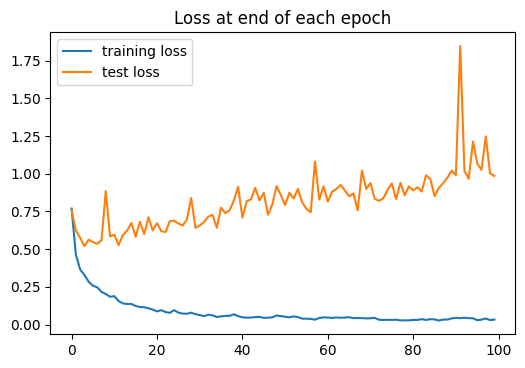

In [47]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses[50:], label = 'training loss')
plt.plot(test_losses[50:], label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Terceiro Treinamento

In [ ]:
#Alterando a learning rate para 0.001

In [50]:
args

{'batch_size': 256,
 'num_workers': 4,
 'num_epochs': 100,
 'learning_rate': 0.001}

In [51]:
args['learning_rate'] = 0.0001

In [53]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomCrop(256, padding=4),
    T.RandomGrayscale(0.1),
    T.RandomAutocontrast(0.1),
    T.RandomHorizontalFlip(0.2),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize([0, 0, 0], [1, 1, 1])
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')


training on cuda:0
epoch 1, train loss 1.2996, train acc 0.638, test loss 1.0606, test acc 0.682, time 0.5 min
epoch 2, train loss 0.8623, train acc 0.729, test loss 1.0166, test acc 0.698, time 0.5 min
epoch 3, train loss 0.7875, train acc 0.750, test loss 0.9817, test acc 0.702, time 0.5 min
epoch 4, train loss 0.7041, train acc 0.777, test loss 0.9733, test acc 0.711, time 0.5 min
epoch 5, train loss 0.6533, train acc 0.791, test loss 0.9017, test acc 0.742, time 0.5 min
epoch 6, train loss 0.6198, train acc 0.799, test loss 0.9008, test acc 0.732, time 0.5 min
epoch 7, train loss 0.5993, train acc 0.806, test loss 0.9345, test acc 0.729, time 0.5 min
epoch 8, train loss 0.5520, train acc 0.818, test loss 0.9517, test acc 0.728, time 0.5 min
epoch 9, train loss 0.5512, train acc 0.821, test loss 0.9752, test acc 0.721, time 0.5 min
epoch 10, train loss 0.5200, train acc 0.829, test loss 0.8771, test acc 0.748, time 0.5 min
epoch 11, train loss 0.4966, train acc 0.838, test loss 1.11

epoch 89, train loss 0.1472, train acc 0.950, test loss 1.2435, test acc 0.761, time 0.5 min
epoch 90, train loss 0.1370, train acc 0.953, test loss 1.2656, test acc 0.752, time 0.5 min
epoch 91, train loss 0.1435, train acc 0.952, test loss 1.3760, test acc 0.743, time 0.5 min
epoch 92, train loss 0.1335, train acc 0.955, test loss 1.2952, test acc 0.753, time 0.5 min
epoch 93, train loss 0.1455, train acc 0.951, test loss 1.3008, test acc 0.762, time 0.5 min
epoch 94, train loss 0.1394, train acc 0.950, test loss 1.3375, test acc 0.766, time 0.5 min
epoch 95, train loss 0.1415, train acc 0.951, test loss 1.3002, test acc 0.759, time 0.5 min
epoch 96, train loss 0.1347, train acc 0.953, test loss 1.2982, test acc 0.767, time 0.5 min
epoch 97, train loss 0.1300, train acc 0.957, test loss 1.2706, test acc 0.768, time 0.5 min
epoch 98, train loss 0.1382, train acc 0.952, test loss 1.3150, test acc 0.751, time 0.5 min
epoch 99, train loss 0.1338, train acc 0.952, test loss 1.3292, test a

Accuracy: 74.69%, Precision: 0.67, Recall: 0.62, F1-Score: 0.64


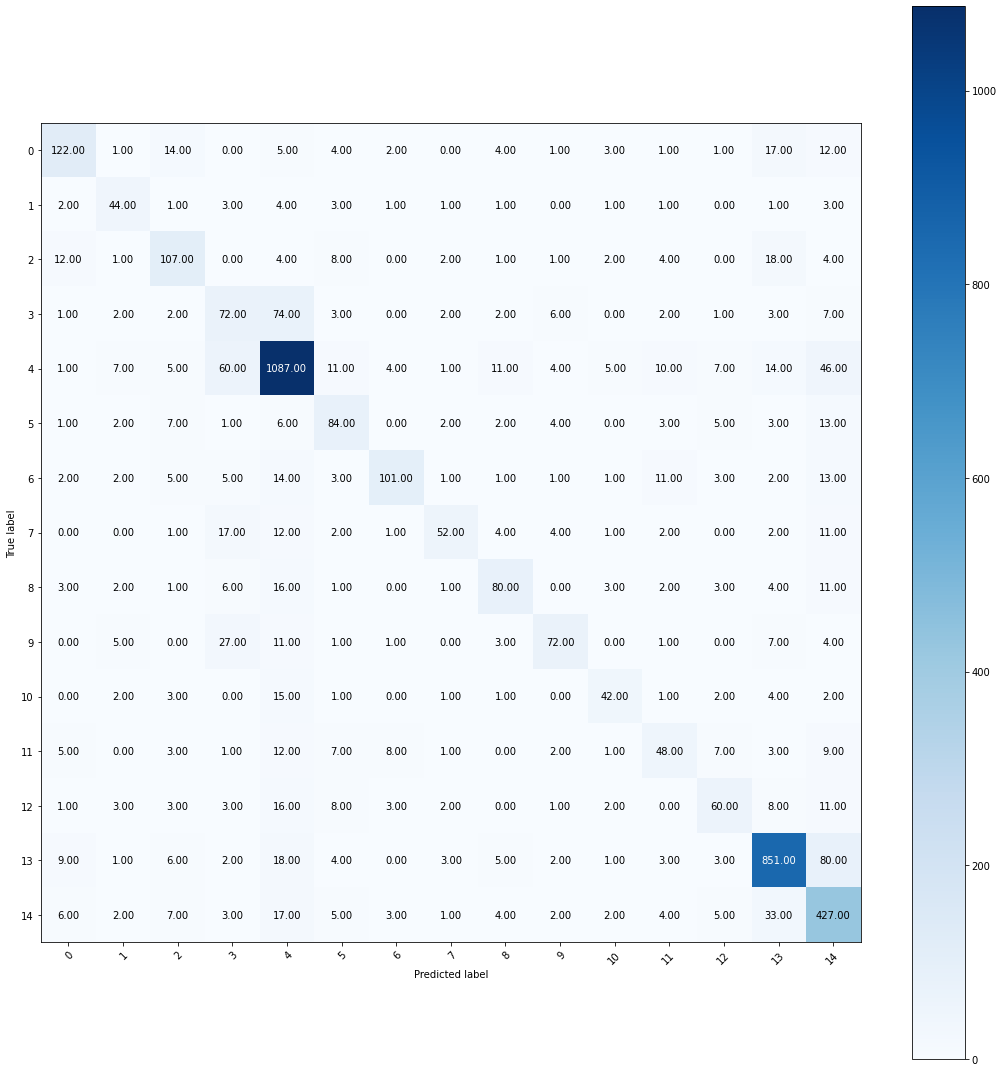

In [54]:
#Acurácia dos dados de teste e matrix de confusão
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

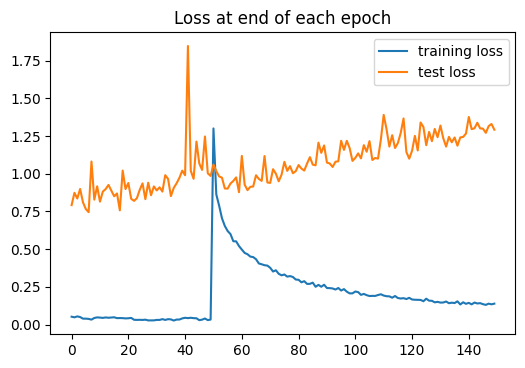

In [56]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses[100:], label = 'training loss')
plt.plot(test_losses[100:], label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Quarto Treinamento

In [68]:
#Diminuindo a learning rate e alterando o número de epochs para 200

In [61]:
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [62]:
args

{'batch_size': 256,
 'num_workers': 4,
 'num_epochs': 100,
 'learning_rate': 0.0001}

In [63]:
args['learning_rate'] = 0.0001
args['num_epochs'] = 200

In [ ]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomGrayscale(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.Resize(224),
    T.ColorJitter(brightness=0.4, contrast=0.25, saturation=0.25, hue=0.1),
    T.ToTensor(),
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

optimizer = optim.Adam(model.parameters(), lr = args['learning_rate'])
train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')

training on cuda:0
epoch 1, train loss 0.3740, train acc 0.884, test loss 0.8088, test acc 0.801, time 1.0 min
epoch 2, train loss 0.2231, train acc 0.927, test loss 0.7378, test acc 0.823, time 1.0 min
epoch 3, train loss 0.1710, train acc 0.942, test loss 0.6886, test acc 0.830, time 1.0 min
epoch 4, train loss 0.1453, train acc 0.951, test loss 0.6557, test acc 0.839, time 1.0 min
epoch 5, train loss 0.1200, train acc 0.961, test loss 0.6653, test acc 0.847, time 1.0 min
epoch 6, train loss 0.1011, train acc 0.968, test loss 0.6754, test acc 0.846, time 1.0 min
epoch 7, train loss 0.0947, train acc 0.969, test loss 0.7144, test acc 0.839, time 1.0 min
epoch 8, train loss 0.0884, train acc 0.970, test loss 0.6938, test acc 0.843, time 1.0 min
epoch 9, train loss 0.0733, train acc 0.977, test loss 0.6978, test acc 0.846, time 1.0 min
epoch 10, train loss 0.0709, train acc 0.977, test loss 0.7006, test acc 0.847, time 1.0 min
epoch 11, train loss 0.0714, train acc 0.976, test loss 0.72

epoch 89, train loss 0.0060, train acc 0.998, test loss 0.8972, test acc 0.863, time 1.0 min
epoch 90, train loss 0.0044, train acc 0.999, test loss 0.9112, test acc 0.862, time 1.0 min
epoch 91, train loss 0.0047, train acc 0.999, test loss 0.9266, test acc 0.861, time 1.0 min
epoch 92, train loss 0.0050, train acc 0.999, test loss 0.9670, test acc 0.861, time 1.0 min
epoch 93, train loss 0.0044, train acc 0.999, test loss 0.9694, test acc 0.861, time 1.0 min
epoch 94, train loss 0.0044, train acc 0.999, test loss 0.9642, test acc 0.859, time 1.0 min
epoch 95, train loss 0.0052, train acc 0.998, test loss 0.9701, test acc 0.859, time 1.0 min
epoch 96, train loss 0.0048, train acc 0.999, test loss 0.9588, test acc 0.861, time 1.0 min
epoch 97, train loss 0.0038, train acc 0.999, test loss 0.9178, test acc 0.864, time 1.0 min
epoch 98, train loss 0.0033, train acc 0.999, test loss 0.9466, test acc 0.865, time 1.0 min
epoch 99, train loss 0.0041, train acc 0.999, test loss 0.9524, test a

Accuracy: 84.41%, Precision: 0.79, Recall: 0.74, F1-Score: 0.76


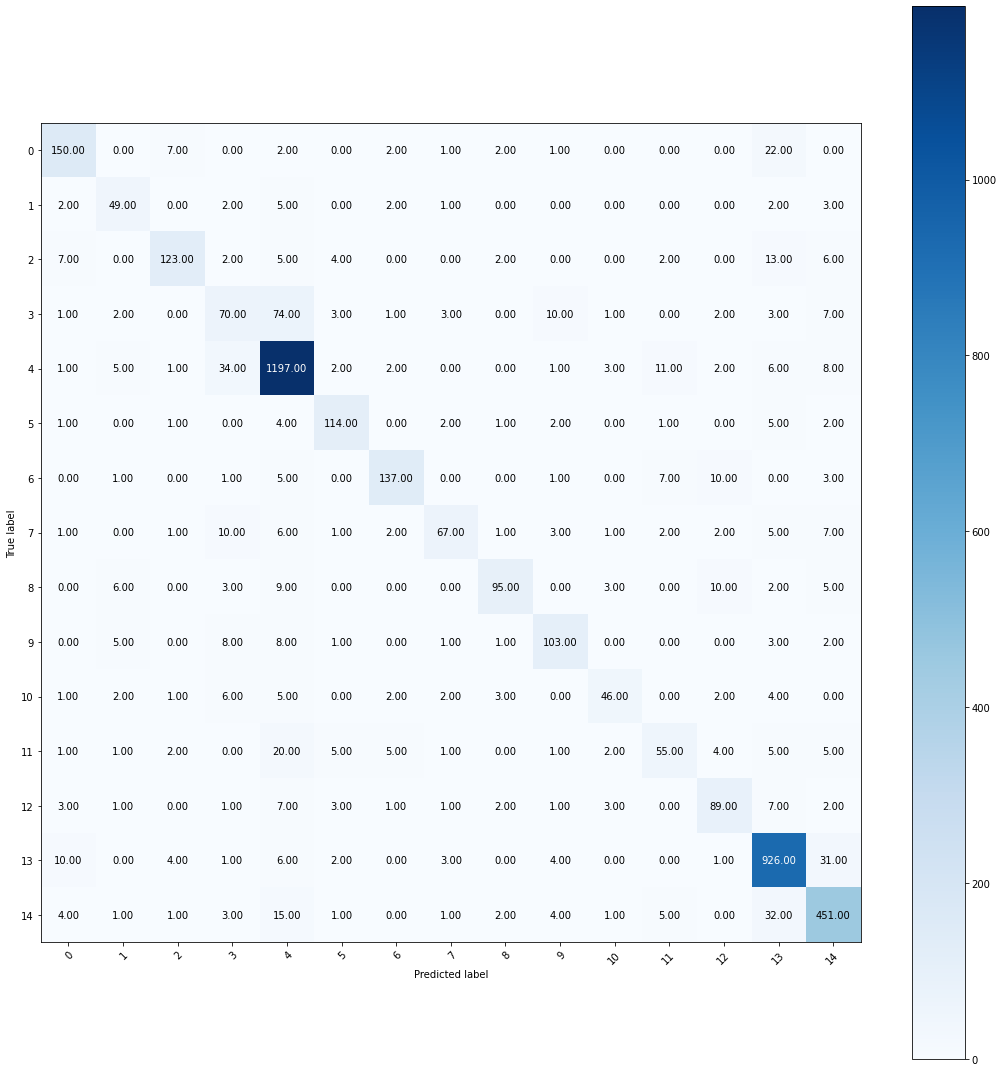

In [65]:
#Acurácia dos dados de teste e matrix de confusão
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

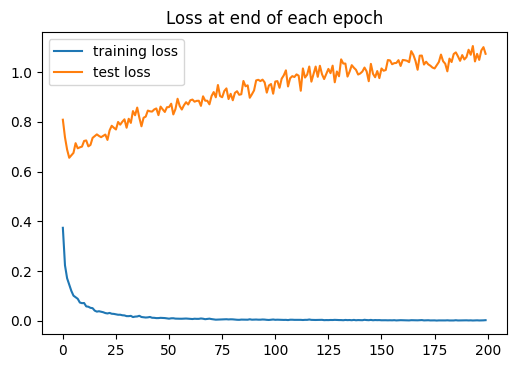

In [67]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()